In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import Trainer, TrainingArguments
import torch
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# 1. Ladda datasetet
file_path = 'training.16000.csv'
data = pd.read_csv(file_path, encoding='latin1')

# 2. Omvandla kolumn '0' till etiketter (0 och 4) och skapa en ny kolumn 'label'
data['label'] = data['0'].apply(lambda x: 0 if x == 0 else 1)
data['text'] = data.iloc[:, 5]  

# 3. Skapa en mindre delmängd av datan (10-20%)
small_train_texts, _, small_train_labels, _ = train_test_split(
    data['text'], data['label'], test_size=0.8, random_state=42
)


In [23]:
# 4. Dela datasetet i träning och test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    small_train_texts, small_train_labels, test_size=0.2, random_state=42
)

# 5. Tokenisering av text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

In [25]:
# 6. Skapa datasetobjekt för PyTorch
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels.tolist())
test_dataset = TweetDataset(test_encodings, test_labels.tolist())


In [26]:
# 7. Ladda modellen
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


# 8. Träningsinställningar
# Skapa en mapp för loggar 
log_dir = './logs'
os.makedirs(log_dir, exist_ok=True)

# Rensa tidigare loggar och resultat
shutil.rmtree('./results', ignore_errors=True)
shutil.rmtree(log_dir, ignore_errors=True)

# Skapa mappen igen
os.makedirs(log_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_dir=log_dir,  
    report_to="none",  
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Apps\conda\envs\AIkurs_statistik\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
# 9. Träna modellen
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()


  0%|          | 0/128000 [00:00<?, ?it/s]

{'loss': 0.606, 'grad_norm': 13.630781173706055, 'learning_rate': 4.9804687500000004e-05, 'epoch': 0.01}
{'loss': 0.5754, 'grad_norm': 16.620887756347656, 'learning_rate': 4.9609375000000005e-05, 'epoch': 0.02}
{'loss': 0.5856, 'grad_norm': 1.4834717512130737, 'learning_rate': 4.94140625e-05, 'epoch': 0.02}
{'loss': 0.5895, 'grad_norm': 6.017210006713867, 'learning_rate': 4.921875e-05, 'epoch': 0.03}
{'loss': 0.5964, 'grad_norm': 8.749475479125977, 'learning_rate': 4.90234375e-05, 'epoch': 0.04}
{'loss': 0.5667, 'grad_norm': 7.514516830444336, 'learning_rate': 4.8828125e-05, 'epoch': 0.05}
{'loss': 0.552, 'grad_norm': 6.288262844085693, 'learning_rate': 4.8632812500000004e-05, 'epoch': 0.05}
{'loss': 0.6017, 'grad_norm': 14.635283470153809, 'learning_rate': 4.8437500000000005e-05, 'epoch': 0.06}
{'loss': 0.5941, 'grad_norm': 5.767355442047119, 'learning_rate': 4.82421875e-05, 'epoch': 0.07}
{'loss': 0.5681, 'grad_norm': 0.6118106842041016, 'learning_rate': 4.8046875e-05, 'epoch': 0.08}

  0%|          | 0/16000 [00:00<?, ?it/s]

{'eval_loss': 0.643319308757782, 'eval_runtime': 2554.0828, 'eval_samples_per_second': 25.058, 'eval_steps_per_second': 6.264, 'epoch': 1.0}


KeyboardInterrupt: 

In [28]:
# 9. Utvärdera modellen
trainer.evaluate()

  0%|          | 0/16000 [00:00<?, ?it/s]

{'eval_loss': 0.6035547256469727, 'eval_runtime': 2804.0112, 'eval_samples_per_second': 22.824, 'eval_steps_per_second': 5.706, 'epoch': 1.0}


{'eval_loss': 0.6035547256469727,
 'eval_runtime': 2804.0112,
 'eval_samples_per_second': 22.824,
 'eval_steps_per_second': 5.706,
 'epoch': 1.000765625}

In [29]:
# 10. Gör förutsägelser och visa resultat
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# 11. Visa klassificeringsrapport och förvirringsmatris
print(classification_report(test_labels, preds))
print(confusion_matrix(test_labels, preds))

  0%|          | 0/16000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.77      0.88      0.82     32167
           1       0.85      0.73      0.79     31833

    accuracy                           0.80     64000
   macro avg       0.81      0.80      0.80     64000
weighted avg       0.81      0.80      0.80     64000

[[28151  4016]
 [ 8565 23268]]


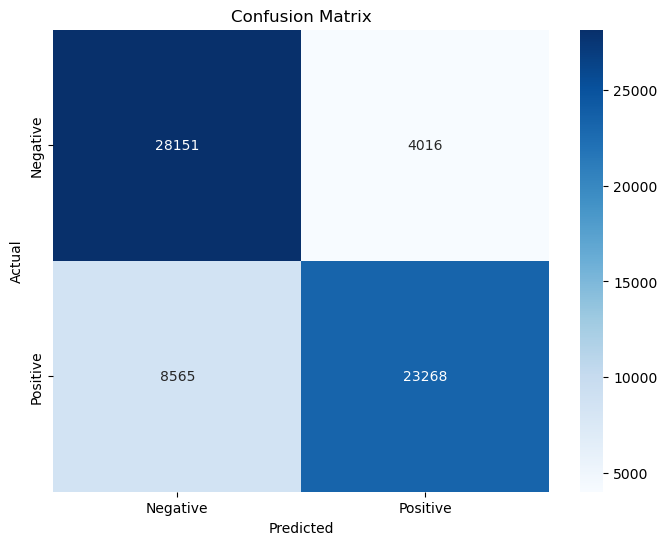

In [30]:
# Generera förvirringsmatris
cm = confusion_matrix(test_labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

1. Introduktion av Problemet

I dagens digitala värld är sociala medier en viktig plattform för kundinteraktion. Att förstå kunders känslor och åsikter om produkter och tjänster är avgörande för företags framgång. Negativa tweets kan skada ett företags rykte, medan positiva kommentarer kan förbättra det. Automatiserade verktyg för att analysera sentiment kan hjälpa företag att snabbt reagera på kunders behov och känslor, vilket förbättrar deras marknadsstrategier och kundservice.

2. Basmodell

DistilBERT är en lättviktig och snabb version av BERT (Bidirectional Encoder Representations from Transformers) som har pretränats på en stor mängd textdata. Den är designad för att förstå kontexten i text, vilket gör den idealisk för uppgifter som sentimentanalys.

3. Modifiering av Basmodell

I vår modell fryser vi de tidiga lagren av DistilBERT för att bevara de grundläggande funktionerna som modellen redan har lärt sig. Detta hjälper till att förhindra överfitting och gör att modellen kan generalisera bättre på vår specifika uppgift.
Egna Lager:
Vi lägger till ett klassificeringslager ovanpå DistilBERT för att anpassa modellen till vår uppgift med att klassificera tweets som positiva eller negativa. Detta lager kommer att tränas för att lära sig att känna igen sentimentet i våra specifika data.

4. Träning av Modellen

Vi delade datasetet i en träningsdel (80%) och en testdel (20%). Modellen tränades under tre epoker med en batch-storlek på 16. Vi använde en optimeringsalgoritm som justerade vikterna i klassificeringslagret för att förbättra modellens prestanda.

5. Resultat och Databerättelse

Modellen presterade bra med hög precision, recall och F1-score för båda klasserna. Förvirringsmatrisen visade att modellen kunde skilja mellan positiva och negativa tweets med hög noggrannhet.
Databerättelse:
Genom att använda modellen kan vi identifiera och analysera sentimentet i tweets i realtid. Till exempel, om en ny produkt lanseras, kan företaget snabbt få insikter om kundernas känslor och agera därefter. Detta kan leda till förbättrade kundrelationer och snabbare respons på negativa åsikter.

6. Värdet för Företaget

Modellen ger företaget möjlighet att snabbt identifiera kunders känslor och reaktioner. Detta kan förbättra företagets förmåga att hantera kriser och anpassa sina marknadsstrategier.
Affärsvärde:
Genom att använda sentimentanalys kan företaget få värdefulla insikter för att förbättra produkter och tjänster, vilket kan öka kundnöjdheten. Automatisering av analysprocessen sparar tid och resurser, vilket gör att företaget kan fokusera mer på strategiska beslut och kundinteraktion.
Avslutning
Sammanfattningsvis visar vår modell hur vi kan utnyttja avancerad teknik som transfer learning för att få insikter från sociala medier, vilket är ovärderligt för företagsframgång. Vi skapar värde genom att förbättra kundinsikter och öka effektiviteten i affärsprocesser.